In [1]:
from SimPEG import Mesh, Utils, EM
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
csx, csy, csz = 100., 100., 100. 
ncx, ncy, ncz, npad = 32, 32, 30, 10
hx = [(csx,npad,-1.3), (csx,ncx), (csx,npad,1.3)]
hy = [(csy,npad,-1.3), (csy,ncy), (csy,npad,1.3)]
# hz = [(csz,npad,-1.4), (csz,12), (50,6),(50,6),(csz,12), (csz,npad,1.4)]
hz = [(csz,npad,-1.3), (csz,12), (50, 6)]
mesh = Mesh.TensorMesh([hx,hy,hz], 'CCN')

# xr = np.linspace(-1200., 1200., 25);
# XYZ = Utils.ndgrid(xr, xr, -1e0*np.ones(1));

In [3]:
blkind1 = Utils.ModelBuilder.getIndicesBlock([-900., -900., -250.], [-400., -400., -650.], mesh.gridCC)
blkind2 = Utils.ModelBuilder.getIndicesBlock([-900.,  400., -250.], [-400., 900., -650.], mesh.gridCC)
blkind3 = Utils.ModelBuilder.getIndicesBlock([400., 400., -250.], [900., 900., -650.], mesh.gridCC)
blkind4 = Utils.ModelBuilder.getIndicesBlock([400., -900., -250.], [900., -400., -650.], mesh.gridCC)
airind = mesh.gridCC[:,2]>0.

background = 1./100.
sigma = np.ones(mesh.nC)*background
sigma[blkind1] = 0.1
sigma[blkind2] = 1.
sigma[blkind3] = 0.01
sigma[blkind4] = 0.001

In [4]:
topoXYZ = Utils.ndgrid(mesh.vectorNx, mesh.vectorNy, np.r_[-1.])

In [5]:
xr = np.linspace(-1200., 1200., 10)
rxlocM = Utils.ndgrid(xr-100., xr, 0.*np.ones(1))
rxlocN = Utils.ndgrid(xr+100., xr, 0.*np.ones(1))
xc1_p, yc1_p, zc1_p = -1500., 0., 0.
xc1_n, yc1_n, zc1_n = 1500., 0., 0. 
srclocA = np.r_[xc1_p, yc1_p, zc1_p] 
srclocB = np.r_[xc1_n, yc1_n, zc1_n]

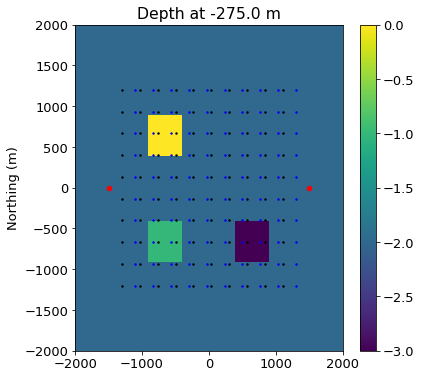

In [6]:
import matplotlib
matplotlib.rcParams["font.size"] = 13
# matplotlib.rcParams["text.use"] = False

indz = 22

fig, ax = plt.subplots(1,1, figsize = (5*1.2,5*1.2))
ph = mesh.plotSlice(np.log10(sigma), ax=ax, grid=False, ind=indz)
plt.scatter(rxlocM[:,0], rxlocM[:,1], 2, color='k')
plt.scatter(rxlocN[:,0], rxlocN[:,1], 2, color='b')

plt.scatter(srclocA[0], srclocA[1], 20, color='r')
plt.scatter(srclocB[0], srclocB[1], 20, color='r')
ax.set_xlim(-2000., 2000.)
ax.set_ylim(-2000., 2000.)
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
ax.set_title(("Depth at %.1f m")%(mesh.vectorCCz[indz]))
ax.set_xlabel(" ")
plt.colorbar(ph[0])
# ax.plot(XYZ[:,0]+100, XYZ[:,1], 'w.')
# ax.plot(XYZ[:,0]-100, XYZ[:,1], 'r.')

plt.savefig('True.png', bbox_inches='tight')


In [7]:
from scipy.interpolate import griddata
from scipy.spatial import cKDTree
from scipy.interpolate.interpnd import _ndim_coords_from_arrays

def plotScatter(xyz, axs=None, fill=True, contour=False, vmin=None, vmax=None, clabel=True, cmap = 'RdBu_r', alpha=1., distMax=1000):
    # Create grid of points
    x = np.linspace(xyz[:, 0].min(), xyz[:, 0].max(), 500)
    y = np.linspace(xyz[:, 1].min(), xyz[:, 1].max(), 500)

    X, Y = np.meshgrid(x, y)

    # Interpolate
    d_grid = griddata(xyz[:, 0:2], xyz[:,2], (X, Y), method='linear')
    
    # Remove points beyond treshold
    tree = cKDTree(xyz[:,:2])
    xi = _ndim_coords_from_arrays((X, Y), ndim=2)
    dists, indexes = tree.query(xi)

    # Copy original result but mask missing values with NaNs
    d_grid[dists > distMax] = np.nan


    im, CS= [], []
    if axs is None:
        axs = plt.subplot()
        
    if fill:
        im = axs.contourf(X, Y, d_grid, 30, vmin=vmin, vmax=vmax, cmap=cmap, alpha=alpha)
        
    if np.any(contour):
        CS = axs.contour(X, Y, d_grid, contour, vmin=vmin, vmax=vmax, cmap=cmap,linewidths=0.5)
        
        if clabel:
            plt.clabel(CS, inline=1, fontsize=10, fmt='%i')
    return im, CS

In [8]:
from SimPEG import Mesh, Utils, Maps, Survey
from SimPEG.EM.Static import DC, IP
from pymatsolver import PardisoSolver
wrType = 'distanceW'

rx = DC.Rx.Dipole(rxlocM, rxlocN)
src = DC.Src.Dipole([rx], srclocA, srclocB)

idenMap = Maps.IdentityMap(nP=mesh.nC)
expmap = Maps.ExpMap(mesh)
logmap = Maps.LogMap(mesh)

m0 = np.log(np.ones_like(sigma)*background/10.) 
mref = np.log(np.ones_like(sigma)*background/10.)
survey = DC.Survey([src])
problem = DC.Problem3D_N(mesh, sigmaMap=expmap, storeJ=True)
problem.Solver = PardisoSolver
problem.pair(survey)
mtrue = np.log(sigma)

# Depth weight
depth = 1./(abs(mesh.gridCC[:,2]))**1.5
depth = depth/depth.max()
d0 = survey.dpred(m0)
dobs = survey.makeSyntheticData(mtrue, std=0.02)

wd = 1./(abs(dobs)*0.01)

Calculating J and storing


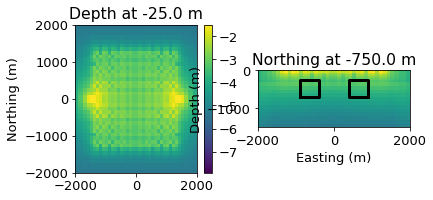

In [9]:
if wrType == 'depthW':
    wr = depth
elif wrType == 'distanceW':
    wr = np.sum((problem.getJ(m0, problem.fields(m0)))**2.,axis=0)**0.5


indz = -1

fig = plt.figure(figsize = (5*1.2,5*1.2))
ax = plt.subplot(2,2,1)
ph = mesh.plotSlice(np.log10(wr), ax=ax, grid=False, ind=indz)
ax.set_xlim(-2000., 2000.)
ax.set_ylim(-2000., 2000.)
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
ax.set_title(("Depth at %.1f m")%(mesh.vectorCCz[indz]))
ax.set_xlabel(" ")
plt.colorbar(ph[0])
# ax.plot(XYZ[:,0]+100, XYZ[:,1], 'w.')
# ax.plot(XYZ[:,0]-100, XYZ[:,1], 'r.')

ax = plt.subplot(2,2,2)
indy1 = 18

mesh.plotSlice(np.log10(wr), ax=ax, grid=False, normal='Y', ind = indy1)
ax.set_xlim(-2000., 2000.)
ax.set_ylim(-1500., 0.)
ax.set_title(("Northing at %.1f m")%(mesh.vectorCCy[indy1]))
ax.set_xlabel("Easting (m)")
# ax.set_xlabel(" ")

ax.set_ylabel("Depth (m)")
rectxzx=np.r_[-900., -400., -400., -900., -900.]
rectxzz=np.r_[-700., -700., -250., -250., -700.]
ax.plot(rectxzx, rectxzz,'k-',lw=3)
ax.plot(-rectxzx, rectxzz,'k-',lw=3)
ax.set_aspect('equal')



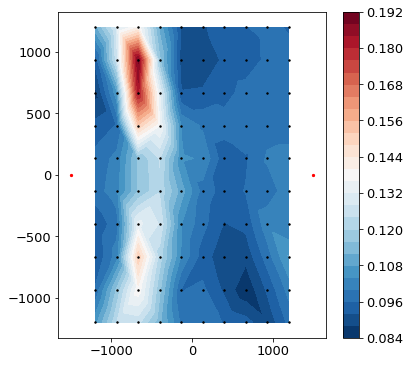

In [10]:
reshalf = 1./background
geom = d0 / reshalf

midLocs = (rxlocM+rxlocN)/2

fig, ax = plt.subplots(1,1, figsize = (5*1.2,5*1.2))
im, CS = plotScatter(np.c_[midLocs[:,:2], 1./(dobs/geom)])

plt.scatter(midLocs[:,0], midLocs[:,1], 2, color='k')
# plt.scatter(rxlocN[:,0], rxlocN[:,1], 2, color='b')

plt.scatter(srclocA[0], srclocA[1], 5, color='r')
plt.scatter(srclocB[0], srclocB[1], 5, color='r')

plt.colorbar(im)

In [20]:
from SimPEG import DataMisfit, Regularization, Optimization, Directives, InvProblem, Inversion

actv = np.asarray(range(mesh.nC))
#TODO put warning when dobs is not set!
survey.dobs = dobs
dmisfit = DataMisfit.l2_DataMisfit(survey)
dmisfit.W = wd
reg = Regularization.Sparse(mesh, indActive=actv, mapping=idenMap)
reg.norms = [2,2,2,2]
reg.mref = mref
reg.eps_p = 1e-1
reg.cell_weights = wr
# opt = Optimization.ProjectedGNCG(maxIter=20, lower=-5, upper=5,
#                                  maxIterLS=20, maxIterCG=10, tolCG=1e-4)
opt = Optimization.InexactGaussNewton(maxIter = 15)

invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt, beta=1e+7)
# Create an inversion object
beta = Directives.BetaSchedule(coolingFactor=5, coolingRate=2)
betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1e0)
# save = Directives.SaveOutputEveryIteration()
target = Directives.TargetMisfit()
update_IRLS = Directives.Update_IRLS(f_min_change=1e-3, minGNiter=2, maxIRLSiter=10)
updateWr = Directives.Update_DC_Wr(wrType=wrType)

inv = Inversion.BaseInversion(invProb, directiveList=[update_IRLS, updateWr])
problem.counter = opt.counter = Utils.Counter()
opt.LSshorten = 0.5
opt.remember('xc')
mopt = inv.run(m0)
# sigopt = mapping*mopt

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***


C:\Users\DominiqueFournier\Documents\GIT\SimPEG\SimPEG\Directives.py:643: UserWarning: Without a Linear preconditioner, convergence may be slow. Consider adding `Directives.Update_lin_PreCond` to your directives list
  "Without a Linear preconditioner, convergence may be slow. "


Calculating J and storing
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.00e+07  4.71e+07  0.00e+00  4.71e+07    2.14e+06      0              
Calculating J and storing
4.25237787248e-09 0.0259604428292
   1  5.00e+06  6.55e+06  1.47e-01  7.28e+06    4.41e+05      0              
Calculating J and storing
1.70734777239e-09 0.0216697896807
   2  2.50e+06  1.27e+06  2.68e-01  1.94e+06    1.37e+05      0   Skip BFGS  
Calculating J and storing
7.88607807858e-10 0.0175842975769
   3  1.25e+06  3.87e+05  3.27e-01  7.96e+05    6.36e+04      0   Skip BFGS  
Calculating J and storing
5.74197120034e-10 0.0140644846459
   4  6.25e+05  1.49e+05  3.66e-01  3.78e+05    3.33e+04      0   Skip BFGS  
Calculating J and storing
5.78505785625e-10 0.0110568420385
   5  3.12

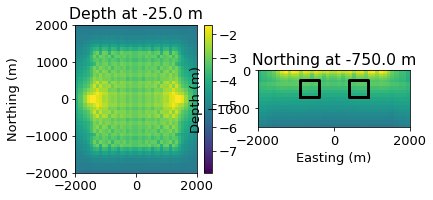

In [21]:
indz = -1

fig = plt.figure(figsize = (5*1.2,5*1.2))
ax = plt.subplot(2,2,1)
ph = mesh.plotSlice(np.log10(np.abs(wr-reg.cell_weights)), ax=ax, grid=False, ind=indz)
ax.set_xlim(-2000., 2000.)
ax.set_ylim(-2000., 2000.)
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
ax.set_title(("Depth at %.1f m")%(mesh.vectorCCz[indz]))
ax.set_xlabel(" ")
plt.colorbar(ph[0])
# ax.plot(XYZ[:,0]+100, XYZ[:,1], 'w.')
# ax.plot(XYZ[:,0]-100, XYZ[:,1], 'r.')

ax = plt.subplot(2,2,2)
indy1 = 18

mesh.plotSlice(np.log10(np.abs(wr-reg.cell_weights)), ax=ax, grid=False, normal='Y', ind = indy1)
ax.set_xlim(-2000., 2000.)
ax.set_ylim(-1500., 0.)
ax.set_title(("Northing at %.1f m")%(mesh.vectorCCy[indy1]))
ax.set_xlabel("Easting (m)")
# ax.set_xlabel(" ")

ax.set_ylabel("Depth (m)")
rectxzx=np.r_[-900., -400., -400., -900., -900.]
rectxzz=np.r_[-700., -700., -250., -250., -700.]
ax.plot(rectxzx, rectxzz,'k-',lw=3)
ax.plot(-rectxzx, rectxzz,'k-',lw=3)
ax.set_aspect('equal')

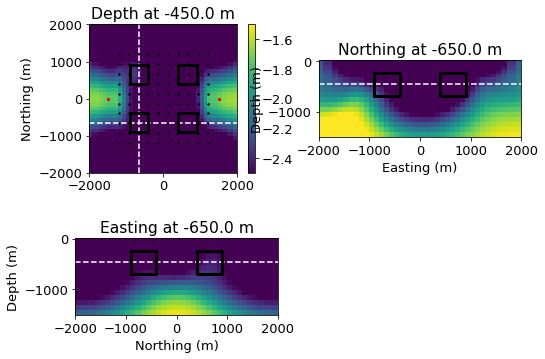

In [23]:
figName = 'DC_Grad_' + wrType +' _l2l2.png'
vmin = -2.5
vmax = -1.5

mout = np.log10(expmap*mopt)

indz= -8
indx1 = 19
indy1 = 19
xlim = [-2000, 2000]
ylim = [-2000, 2000]
zlim = [-1500, 10]

fig, ax = plt.figure(figsize = (8,6)), plt.subplot(2,2,1)
im = mesh.plotSlice(mout, ax=ax, grid=False, ind=indz, clim=(vmin, vmax))
plt.scatter(midLocs[:,0], midLocs[:,1], 2, color='k')
plt.scatter(srclocA[0], srclocA[1], 5, color='r')
plt.scatter(srclocB[0], srclocB[1], 5, color='r')

plt.plot(xlim, np.r_[mesh.vectorCCy[indy1],mesh.vectorCCy[indy1]], 'w--')
plt.plot(np.r_[mesh.vectorCCx[indx1],mesh.vectorCCx[indx1]], ylim, 'w--')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
# ax.set_xlabel("Easting (m)")
ax.set_xlabel(" ")
ax.set_ylabel("Northing (m)")
ax.set_title(("Depth at %.1f m")%(mesh.vectorCCz[indz]))
rectxyx=np.r_[-900., -400., -400., -900., -900.]
rectxyy=np.r_[-900., -900., -400., -400., -900.]
ax.plot(rectxyx, rectxyy,'k-',lw=3)
ax.plot(rectxyx, -rectxyy,'k-',lw=3)
ax.plot(-rectxyx, rectxyy,'k-',lw=3)
ax.plot(-rectxyx, -rectxyy,'k-',lw=3)
plt.colorbar(im[0])
ax.set_aspect('equal')

ax = plt.subplot(2,2,2)


im = mesh.plotSlice(mout, ax=ax, grid=False, normal='Y', clim=(vmin, vmax), ind = indy1)
plt.plot(xlim,np.r_[mesh.vectorCCz[indz],mesh.vectorCCz[indz]], 'w--')
ax.set_xlim(xlim)
ax.set_ylim(zlim)
ax.set_title(("Northing at %.1f m")%(mesh.vectorCCy[indy1]))
ax.set_xlabel("Easting (m)")
# ax.set_xlabel(" ")

ax.set_ylabel("Depth (m)")
rectxzx=np.r_[-900., -400., -400., -900., -900.]
rectxzz=np.r_[-700., -700., -250., -250., -700.]
ax.plot(rectxzx, rectxzz,'k-',lw=3)
ax.plot(-rectxzx, rectxzz,'k-',lw=3)
ax.set_aspect('equal')

ax = plt.subplot(2,2,3)


im = mesh.plotSlice(mout, ax=ax, grid=False, normal='X', clim=(vmin, vmax), ind = indx1)
plt.plot(ylim,np.r_[mesh.vectorCCz[indz],mesh.vectorCCz[indz]], 'w--')
ax.set_xlim(ylim)
ax.set_ylim(zlim)
ax.set_title(("Easting at %.1f m")%(mesh.vectorCCx[indx1]))
ax.set_xlabel("Northing (m)")
# ax.set_xlabel(" ")

ax.set_ylabel("Depth (m)")
rectxzx=np.r_[-900., -400., -400., -900., -900.]
rectxzz=np.r_[-700., -700., -250., -250., -700.]
ax.plot(rectxzx, rectxzz,'k-',lw=3)
ax.plot(-rectxzx, rectxzz,'k-',lw=3)
ax.set_aspect('equal')

plt.savefig(figName, bbox_inches='tight')

In [24]:
reg.mref

array([-6.90775528, -6.90775528, -6.90775528, ..., -6.90775528,
       -6.90775528, -6.90775528])

(-0.5, 0.5)

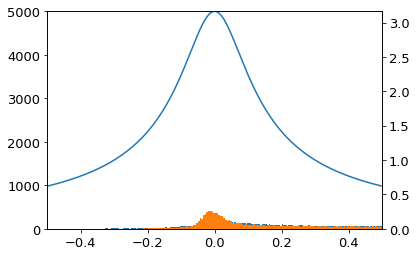

In [15]:
reg.model= mopt
reg.mref= mref
reg.objfcts[0]._stashedR = None
r=(reg.objfcts[0].R(reg.objfcts[0].f_m))
indx = np.argsort((mopt - reg.mref))

lim_val = 0.5

plt.figure()
ax = plt.subplot()
ind = np.abs(invProb.l2model - reg.mref) < lim_val 
temp = plt.hist((invProb.l2model - reg.mref)[ind],200)

ind = np.abs(mopt - reg.mref) < lim_val 
temp = plt.hist((mopt - reg.mref)[ind],200)
ax.set_xlim([-lim_val , lim_val ])
ax.set_ylim([0, 5e+3])
# plt.figure()
ax1 = ax.twinx()
plt.plot(((mopt - reg.mref))[indx], r[indx])
ax1.set_ylim([0, r.max()])
ax.set_xlim([-lim_val , lim_val ])

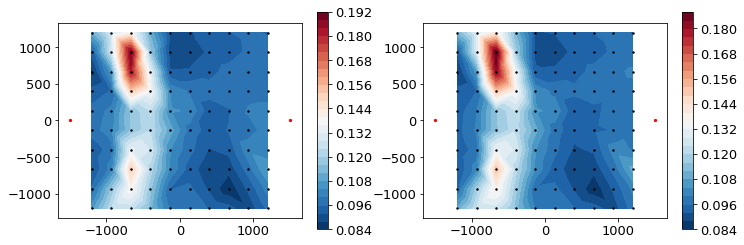

In [16]:
reshalf = 1./background
geom = d0 / reshalf

fig = plt.figure(figsize = (12,4))
ax = plt.subplot(1,2,1) 
im, CS = plotScatter(np.c_[midLocs[:,:2], 1./(dobs/geom)], axs=ax)
plt.scatter(midLocs[:,0], midLocs[:,1], 2, color='k')
# plt.scatter(rxlocN[:,0], rxlocN[:,1], 2, color='b')

plt.scatter(srclocA[0], srclocA[1], 5, color='r')
plt.scatter(srclocB[0], srclocB[1], 5, color='r')
plt.colorbar(im)
ax.set_aspect('equal')
ax = plt.subplot(1,2,2) 
im, CS = plotScatter(np.c_[midLocs[:,:2], 1./(invProb.dpred/geom)], axs=ax)
plt.scatter(midLocs[:,0], midLocs[:,1], 2, color='k')
# plt.scatter(rxlocN[:,0], rxlocN[:,1], 2, color='b')

plt.scatter(srclocA[0], srclocA[1], 5, color='r')
plt.scatter(srclocB[0], srclocB[1], 5, color='r')
plt.colorbar(im)
ax.set_aspect('equal')


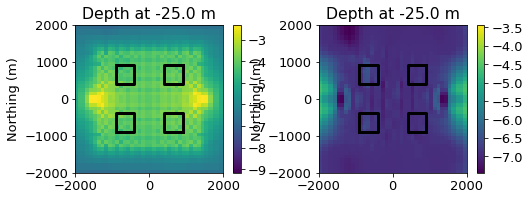

In [17]:
figName = 'DC_Grad_SensW.png'
vmin = -4
vmax = -1.

indz= -1
fig, ax = plt.figure(figsize = (8,6)), plt.subplot(2,2,1)
im = mesh.plotSlice(np.log10(reg.cell_weights), ax=ax, grid=False, ind=indz)
ax.set_xlim(-2000., 2000.)
ax.set_ylim(-2000., 2000.)
# ax.set_xlabel("Easting (m)")
ax.set_xlabel(" ")
ax.set_ylabel("Northing (m)")
ax.set_title(("Depth at %.1f m")%(mesh.vectorCCz[indz]))
rectxyx=np.r_[-900., -400., -400., -900., -900.]
rectxyy=np.r_[-900., -900., -400., -400., -900.]
ax.plot(rectxyx, rectxyy,'k-',lw=3)
ax.plot(rectxyx, -rectxyy,'k-',lw=3)
ax.plot(-rectxyx, rectxyy,'k-',lw=3)
ax.plot(-rectxyx, -rectxyy,'k-',lw=3)
plt.colorbar(im[0])
ax.set_aspect('equal')

ax = plt.subplot(2,2,2)
im = mesh.plotSlice((mopt), ax=ax, grid=False, ind=indz)
ax.set_xlim(-2000., 2000.)
ax.set_ylim(-2000., 2000.)
# ax.set_xlabel("Easting (m)")
ax.set_xlabel(" ")
ax.set_ylabel("Northing (m)")
ax.set_title(("Depth at %.1f m")%(mesh.vectorCCz[indz]))
rectxyx=np.r_[-900., -400., -400., -900., -900.]
rectxyy=np.r_[-900., -900., -400., -400., -900.]
ax.plot(rectxyx, rectxyy,'k-',lw=3)
ax.plot(rectxyx, -rectxyy,'k-',lw=3)
ax.plot(-rectxyx, rectxyy,'k-',lw=3)
ax.plot(-rectxyx, -rectxyy,'k-',lw=3)
plt.colorbar(im[0])
ax.set_aspect('equal')

In [18]:
def vizdata(dtype = "appres"):    
    if dtype=="appres":
        dataIP0 = (1./(dobs/geom)).reshape((25, 25), order='F')
        dataIP = (1./(dpred/geom)).reshape((25, 25), order='F')
    elif dtype=="potential":
        dataIP0 = (dobs).reshape((25, 25), order='F')
        dataIP = (dpred).reshape((25, 25), order='F')        
        
    fig, ax = plt.subplots(1,2, figsize = (12,4.5))
    
    X, Y = XYZ[:,0].reshape((25, 25), order='F'), XYZ[:,1].reshape((25, 25), order='F')
    vmin, vmax = dataIP0.min(), dataIP0.max()
    dat0 = ax[0].contourf(X, Y, dataIP0, 30, vmin=vmin, vmax=vmax, clim=(vmin, vmax))    
    cb0 = plt.colorbar(dat0, ax=ax[0],format='%.0e')
    dat1 = ax[1].contourf(X, Y, dataIP, 30, vmin=vmin, vmax=vmax, clim=(vmin, vmax))    
    cb1 = plt.colorbar(dat0, ax=ax[1],format='%.0e')
    if dtype=="appres":
#         cb0.set_label("Apparent resistivity (ohm-m)")
        cb1.set_label("Apparent conductivity (S/m)")
    elif dtype=="potential":
#         cb0.set_label("Voltage (V)")
        cb1.set_label("Voltage (V)")    
    ax[0].set_title("Observed data")
    ax[1].set_title("Predicted data")
    for i in range(2):
        ax[i].set_xlabel("Easting (m)")
        if i==0:
            ax[i].set_ylabel("Northing (m)")

In [19]:
vizdata(dtype="potential")

ValueError: cannot reshape array of size 100 into shape (25,25)

In [ ]:
vizdata(dtype="appres")

In [ ]:
fig = plt.figure(figsize = (12,4.5))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
xr = np.linspace(-1200., 1200., 25);
XYZ = Utils.ndgrid(xr, xr, -1e0*np.ones(1));
temp = -dobs.copy()
DOBS = temp.reshape((25, 25), order='F')
appcond = (1./(dobs/geom))
APPCOND = appcond.reshape((25, 25), order='F')
X, Y = XYZ[:,0].reshape((25, 25), order='F'), XYZ[:,1].reshape((25, 25), order='F')
dat1 = ax1.contourf(X, Y, DOBS, 20)    
dat2 = ax2.contourf(X, Y, APPCOND, 20)    

cb = plt.colorbar(dat1, ax=ax1, ticks=np.linspace(temp.min(), temp.max(), 3), format="%.3f")
cb.set_label("Voltage (V)")
cb = plt.colorbar(dat2, ax=ax2, ticks=np.linspace(appcond.min(), appcond.max(), 3), format="%.3f")
cb.set_label("Apparent conductivity (S/m)")

ax1.set_xlabel("Easting (m)")
ax1.set_ylabel("Northing (m)")
ax2.set_xlabel("Easting (m)")
ax1.set_title("(a) DC voltage")
ax2.set_title("(b) Apparent conductivity")
anomalies = ["A1", " ", "A2", "A3"]
x_a = np.r_[-120-650,-120+650,-120-650,-120+650]
y_a = np.r_[550, 550, -550-200, -550-200]+450.
cols = ["w", "w", "w", "w"]

for j in range(4):
    ax1.text(x_a[j], y_a[j], anomalies[j], color=cols[j], fontsize = 20)
    ax2.text(x_a[j], y_a[j], anomalies[j], color=cols[j], fontsize = 20)
ax1.set_aspect('equal')
ax2.set_aspect('equal')
plt.tight_layout()